# Numerically solving differential equations with R

*This is a brief description of what numerical integration is and a practical tutorial on how to do it in R.*


## Software required
### R
*In order to run the R codes in this notebook in your own computer, you need to install the following software:*

* [R](http://www.r-project.org/), along with the packages from [CRAN](http://cran.r-project.org/):
  * [deSolve](http://www.vps.fmvz.usp.br/CRAN/web/packages/deSolve/index.html), a library for solving differential equations
  * [ggplot2](http://www.vps.fmvz.usp.br/CRAN/web/packages/ggplot2/index.html), a library for plotting
  * [reshape2](http://cran.r-project.org/web/packages/reshape2/index.html), for manipulating data.frames

To install R, download it from its homepage (Windows or Mac): http://www.r-project.org/. On Linux, you can install it using your distribution's prefered way, e.g.:

* Debian/Ubuntu: `sudo apt-get install r-base`
* Fedora: `sudo yum install R`
* Arch: `sudo pacman -S r`

To install the packages, all you have to do is run the following in the `R` prompt

    install.packages(c("deSolve", "ggplot2", "reshape2"))
 
The R code presented here and some additional examples are available at https://github.com/diogro/ode_examples (thanks, [Diogro](https://github.com/diogro)!).

### Running commands in  R
You can also follow the instructions in this notebook and run the commands in R in two ways:
* Copy the R codes snippets in this notebook and paste them in the R promt. Alternatively you can save them in a pure text file with .r or .R extension and run directly in an R shell.
* Download the [R script](https://github.com/diogro/ode_examples) and run the commands in a R shell.

### Running R commands from Jupyter
*To run the R commands in this notebook from IP[y] you need also:*

* the [Jupyter notebook](http://jupyter.readthedocs.org/en/latest/install.html) and
* the [R Kernel for Jupyter](http://irkernel.github.io/).

To install the notebook on Windows and Mac, we recommend installing the [Anaconda distribution](https://store.continuum.io/cshop/anaconda/), available at http://continuum.io/downloads. On Linux it should be available from your distro's repositories.

The R kernel can be installed running, on the R shell:

    install.packages(c('rzmq','repr','IRkernel','IRdisplay'),
        repos = c('http://irkernel.github.io/', getOption('repos')))
    IRkernel::installspec()

### Running from the web
If you for some reason don' want to install anything on your computer, you can use a service that runs notebooks on the cloud, e.g. [SageMathCloud](https://cloud.sagemath.com/) or [wakari](https://www.wakari.io/). It is possible to visualize publicly-available notebooks on http://nbviewer.ipython.org, but no computation can be performed (it just shows saved pre-calculated results).



## How numerical integration works

Let's say we have a differential equation that we don't know how (or don't want) to derive its (analytical) solution. We can still find out what the solutions are through **numerical integration**. So, how does that work?

The idea is to approximate the solution at successive small time intervals, extrapolating the value of the derivative over each interval. For example, let's take the differential equation

$$ \frac{dx}{dt} = f(x) = x (1 - x) $$

with an initial value $x_0 = 0.1$ at an initial time $t=0$ (that is, $x(0) = 0.1$). At $t=0$, the derivative $\frac{dx}{dt}$ values $f(0.1) = 0.1 \times (1-0.1) = 0.09$. We pick a small interval step, say, $\Delta t = 0.5$, and assume that the derivative value is a good approximation to the function over the whole interval from $t=0$ up to $t=0.5$. This means that in this time $x$ is going to increase by $\frac{dx}{dt} \times \Delta t = 0.09 \times 0.5 = 0.045$. So our approximate solution for $x$ at $t=0.5$ is $x(0) + 0.045 = 0.145$. We can then use this value of $x(0.5)$ to calculate the next point in time, $t=1$. We calculate the derivative at each step, multiply by the time step and add to the previous value of the solution, as in the table below:

| $t$ | $x$      | $\frac{dx}{dt}$  |
| ---:|---------:|----------:|
| 0   | 0.1      |  0.09     |
| 0.5 | 0.145    |  0.123975 |
| 1.0 | 0.206987 |  0.164144 |
| 1.5 | 0.289059 |  0.205504 |
| 2.0 | 0.391811 |  0.238295 |

Of course, this is terribly tedious to do by hand, so we can write a simple program to do it and plot the solution. Below we compare it to the known analytical solution of this differential equation (the *logistic equation*). **Don't worry about the code just yet**: there are better and simpler ways to do it!

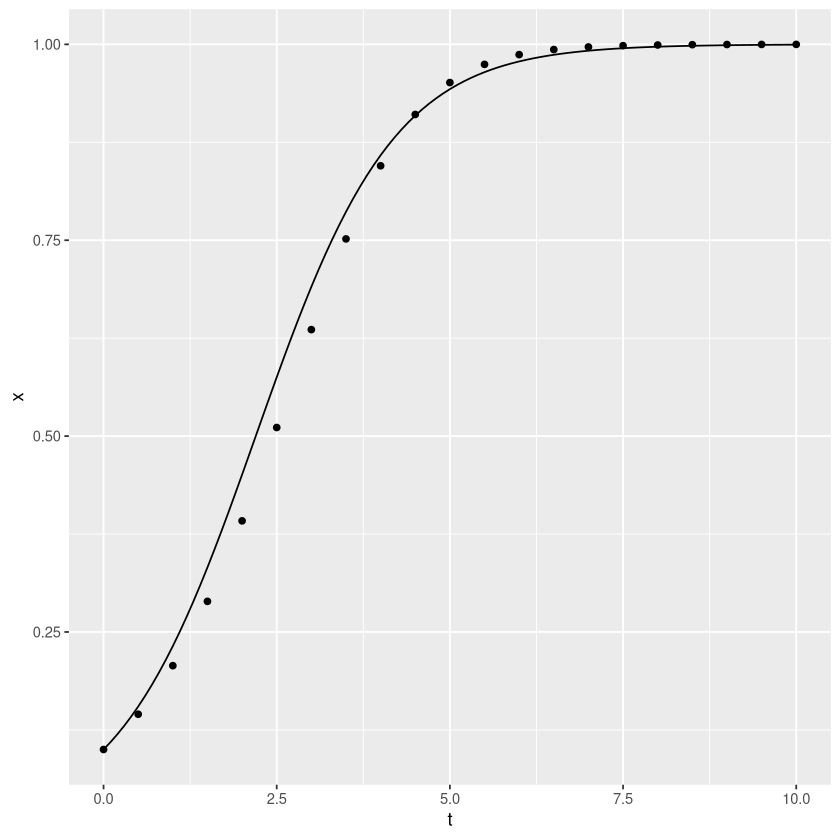

In [1]:
# time intervals: a sequence from zero to ten at 0.5 steps
time <- seq(0, 10, by = 0.5)
# initial condition
x0 <- 0.1
## The function to be integrated (right-hand expression of the derivative above)
f <- function(x){x * (1.-x)}

## An empty R vector to store the results
x <- c()
## Store the initial condition in the first position of the vector
x[1] <- x0

# loop over time: approximate the function at each time step
for (i in 1:(length(time)-1)){
    x[i+1] = x[i] + 0.5 * f(x[i])
}

## plotting with ggplot2
library(ggplot2)#load each library once per R session
p <- ggplot(data = data.frame(x = x, t = time), aes(t, x)) + geom_point()
analytic <- stat_function(fun=function(t){0.1 * exp(t)/(1+0.1*(exp(t)-1.))})
print(p+analytic)

## Why use scientific libraries?

The method we just used above is called the *Euler method*, and is the simplest one available. The problem is that, although it works reasonably well for the differential equation above, in many cases it doesn't perform very well. There are many ways to improve it: in fact, there are many books entirely dedicated to this. Although many math or physics students do learn how to implement more sophisticated methods, the topic is really deep. Luckily, we can rely on the expertise of lots of people to come up with good algorithms that work well in most situations.

## Then, how... ?

We are going to demonstrate how to use scientific libraries to integrate differential equations. Although the specific commands depend on the software, the general procedure is usually the same:

* define the derivative function (the right hand side of the differential equation)
* choose a time step or a sequence of times where you want the solution
* provide the parameters and the initial condition
* pass the function, time sequence, parameters and initial conditions to a computer routine that runs the integration.

### A single equation

So, let's start with the same equation as above, the logistic equation, now with any parameters for growth rate and carrying capacity:

$$ \frac{dx}{dt} = f(x) = r x \left(1 - \frac{x}{K} \right) $$

with $r=2$, $K=10$ and $x(0) = 0.1$. We show how to integrate it using the desolve package below, introducing key language syntax as necessary. We'll use the [deSolve](http://desolve.r-forge.r-project.org/), the most popular R library to run  numerical integration. The basic workflow recommended by the authors of the package is

#### 1. Declare initial conditions, parameters, time interval

In [ ]:
library(deSolve)# loads the library

## time sequence
time <- seq(from=0, to=10, by = 0.01)
# parameters: a named vector
parameters <- c(r = 1.5, K = 10)

# initial conditions: also a named vector
state <- c(x = 0.1)

#### 2. Define a function in R for the ODE to be integrated

Let's define the right-hand side of the differential equation. 
To be recognized by the integration routines of *deSolve*
it must be an R function that computes the values
of the derivative on a time $t$. 
There are many ways to do this, but the recommended format is:
* Make a function with three arguments: time sequence, state variables and parameters, in this order.
* The function should return a list with results of the function to be integrated. 
To do this use `with(as.list(c(state, parameters){ ... }` inside the R function.
Include between brackets the function(s) to be integrated
and then close returning the list of the calculated values.

In [ ]:
## The logistic ODE to be integrated
logistic <- function(t, state, parameters){
    with(
        as.list(c(state, parameters)),{
            dx <- r*x*(1-x/K)
            return(list(dx))
        }
        )
}

#### 3. Integrate the function

Now call the R function `ode`, to perform the integration the basic arguments of 'ode' are
* `y`: the vector of initial conditions
* `times`: the vector with the time sequence
* `func`: the R function as described above
* `parms`: vector of parameter values (named)

In [ ]:
out <- ode(y = state, times = time, func = logistic, parms = parameters)

The resulting object has the values of the integration
at each time point in the vector of times

In [ ]:
head(out) # first 6 lines

which you can plot with

In [ ]:
#### For jupyter notebook only
options(jupyter.plot_mimetypes = 'image/png', repr.plot.height=5)
####

plot(out, lwd=6, col="lightblue", main="", ylab="N(t)")
curve(0.1*10*exp(1.5*x)/(10+0.1*(exp(1.5*x)-1)), add=TRUE)
legend("topleft", c("Numerical", "Analytical"), lty=1, col=c("lightblue", "black"), lwd=c(6,1))

We get a much better approximation now, the two curves superimpose each other!
The get the same plot with *ggplot2* package use:

In [ ]:
## Ploting with ggplot2
p <- ggplot(data = as.data.frame(out), aes(time, x)) + geom_point()
analytic <- stat_function(fun=function(t){0.1*10*exp(1.5*t)/(10+0.1*(exp(1.5*t)-1))})
print(p+analytic)


### A system of equations
Now, what if we wanted to integrate a system of differential equations? Let's take the Lotka-Volterra equations:

$$ \begin{aligned}
\frac{dV}{dt} &= r V - c V P\\
\frac{dP}{dt} &= ec V P - dP
\end{aligned}$$

All that you have to do is to write an R function that returns the values of both derivatives at each time, and to define the values of the parameters and of the initial conditions:

In [ ]:
# time sequence 
time <- seq(0, 50, by = 0.01)

# parameters: a named vector
parameters <- c(r = 2, k = 0.5, e = 0.1, d = 1)

# initial condition: a named vector
state <- c(V = 1, P = 3)

# R function to calculate the value of the derivatives at each time value
# Use the names of the variables as defined in the vectors above
lotkaVolterra <- function(t, state, parameters){
  with(as.list(c(state, parameters)), {
    dV = r * V - k * V * P
    dP = e * k * V * P - d * P
    return(list(c(dV, dP)))
  })
}
## Integration with 'ode'
out <- ode(y = state, times = time, func = lotkaVolterra, parms = parameters)

## Ploting
out.df = as.data.frame(out) # required by ggplot: data object must be a data frame
library(reshape2)
out.m = melt(out.df, id.vars='time') # this makes plotting easier by puting all variables in a single column

p <- ggplot(out.m, aes(time, value, color = variable)) + geom_point()
print(p)

An interesting thing to do here is take a look at the *phase space*, that is, plot only the dependent variables, without respect to time:

In [ ]:
p2 <- ggplot(data = out.df[1:567,], aes(x = P, V, color = time)) + geom_point()
print(p2)

**Congratulations**: you are now ready to integrate any system of differential equations!

### For more info:

* [Introduction to R](cran.r-project.org/doc/manuals/R-intro.html)
* [Crash course in R](http://www.r-bloggers.com/a-crash-course-in-r/)
* [ode package](http://desolve.r-forge.r-project.org/)
* [Some additional example codes](https://github.com/diogro/ode_examples)
* [ggplot2 package](http://ggplot2.org/)
* [A R graph gallery](http://www.sr.bham.ac.uk/~ajrs/R/r-gallery.html)
* [Another tutorial on numerical integration in R](http://www.r-bloggers.com/learning-r-parameter-fitting-for-models-involving-differential-equations/)